# Fama French

In [34]:
import quantstats as qs
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff
import datetime as dt

import numpy as np 
# Used to grab the stock prices, with yahoo 
import pandas_datareader as web 
#from datetime import datetime 
# To visualize the results 
import matplotlib.pyplot as plt 
import seaborn
import quantstats as qs

class StockAnalysis:
    def __init__(self,tickers,start_date=None):
        if(start_date == None):
            self.start = dt.datetime.now() - dt.timedelta(days=365)
        else:
            self.start=start_date
        self.tickers = tickers
         
        self.data = self.get_data()

    # gets data from yahoo finance
    def get_data(self,data_source = "yahoo",tickers= []):
        symbols=[]
        if(len(tickers) == 0):
            tickers=self.tickers

        for ticker in tickers:  
            try:   
                r = web.DataReader(ticker,data_source, self.start) 
            except :
                print(ticker)
            
                continue  
            # add a symbol column   
            r['Symbol'] = ticker    
            symbols.append(r)
        # concatenate into df
        df = pd.concat(symbols)
        df = df.reset_index()
        df = df[['Date', 'Close', 'Symbol']]
        df_pivot=df.pivot('Date','Symbol','Close').reset_index()
        df_pivot.set_index("Date",inplace=True)
        return df_pivot

    # add more stocks
    def addTicker(self,ticker):
        self.tickers += ticker
        self.get_data()

    # get cporrelation metween all stocks added
    def correlation_matrix(self):
        # we are using pearson correlation coefficient
        corr_df = self.data.corr(method='pearson')
        #reset symbol as index (rather than 0-X)
        corr_df.head().reset_index()
        #del corr_df.index.name
        plt.figure(figsize=(13, 8))
        seaborn.heatmap(corr_df, annot=True, cmap='RdYlGn')
        plt.figure()

        return corr_df
    
    # get correlation matrix between two stocks
    def correlationTwoStocks(self,stock1,stock2):
        symbols = [stock1,stock2]
        data = self.get_data(tickers=symbols)
        corr_df = data.corr(method='pearson')
        #reset symbol as index (rather than 0-X)
        corr_df.head().reset_index()
        #del corr_df.index.name
        return corr_df

    # sharpe ratio for all stocks
    def getSharpeRatio(self):
        
        return qs.stats.sharpe(self.data)


# fama - french 3 factor model data from python famafrenchfactor library
    def getfamaFrench3FactorData(self):
        ff3_monthly = gff.famaFrench3Factor(frequency='m')
        ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
        ff3_monthly.set_index('Date', inplace=True)
        
        return ff3_monthly

# fama-french 3 factor model expected yealry return for aparticular stock
    def yearlyExpectedReturnsFamaFrench(self,ticker):
        ff3_monthly = self.getfamaFrench3FactorData()
        if(ticker not in self.tickers):
            print("Ticker not present")
            return None
        # getting ticker data
        stock_returns = self.data[ticker].resample('M').last().pct_change().dropna() # calculate the percentage change of the last price of monthly data compared with the previous month.
        stock_returns.name = "Month_Rtn"
        ff_data = ff3_monthly.merge(stock_returns,on='Date') # merge the calculated stock returns data with the Fama-French benchmark dataframe.
        # ff_data.head()

        # running linear regression to find the beta coefficients
        X = ff_data[['Mkt-RF', 'SMB', 'HML']] 
        y = ff_data['Month_Rtn'] - ff_data['RF'] 
        X = sm.add_constant(X) # addding constant 
        ff_model = sm.OLS(y, X).fit()
        print(ff_model.summary())
        intercept, b1, b2, b3 = ff_model.params

        # calculating expected eyarly returns
        rf = ff_data['RF'].mean()
        market_premium = ff3_monthly['Mkt-RF'].mean()
        size_premium = ff3_monthly['SMB'].mean()
        value_premium = ff3_monthly['HML'].mean()

        expected_monthly_return = rf + b1 * market_premium + b2 * size_premium + b3 * value_premium 
        expected_yearly_return = expected_monthly_return * 12
        print("Expected yearly return: " + str(expected_yearly_return))

        return [expected_yearly_return,intercept, b1, b2, b3]

    def basic_metrics(self):
        #data=pd.DataFrame(index = self.data.columns)
        metrics = []
        for i in self.data.columns:
            metric= qs.reports.metrics(self.data[i],mode='basic',display=False)
            metrics.append(metric)

        data = pd.concat(metrics,axis=1)

        data.columns = self.data.columns
        
        return data


<AxesSubplot:xlabel='Date'>

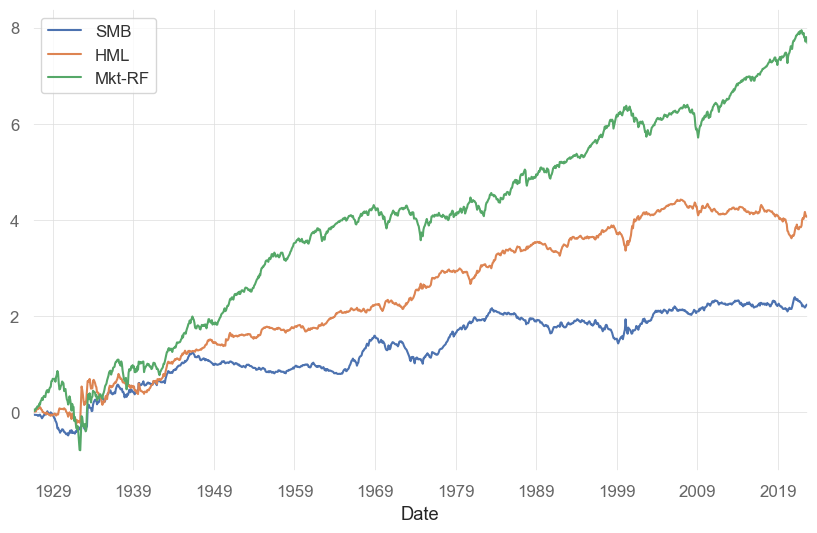

In [18]:
ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)



<AxesSubplot:title={'center':'SMB,HML, Mkt-Rf Cumulative Returns'}, xlabel='Year', ylabel='Cumulative returns'>

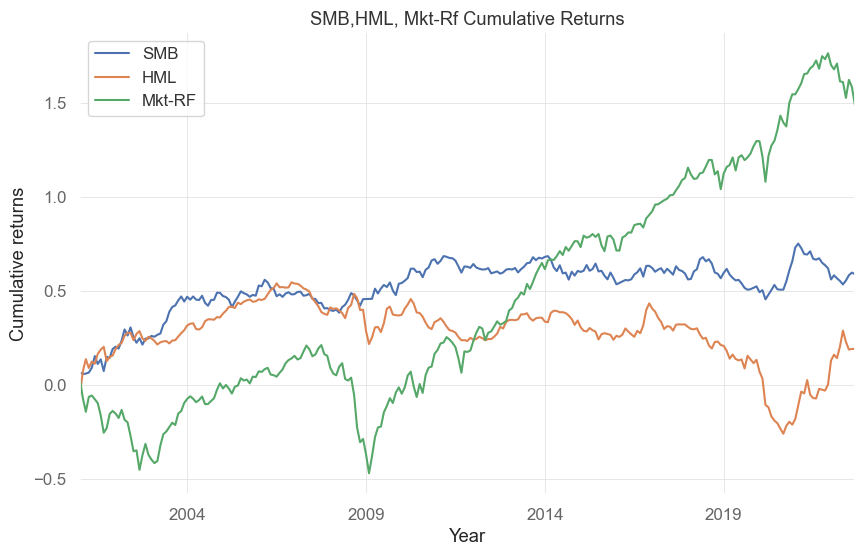

In [29]:
ff3_monthly[ff3_monthly.index >'2001-01-01'].cumsum()[['SMB','HML','Mkt-RF']].plot(title="SMB,HML, Mkt-Rf Cumulative Returns",xlabel="Year",ylabel='Cumulative returns')


In [16]:
ff3_monthly

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1926-08-31,0.0264,-0.0117,0.0382,0.0025
1926-09-30,0.0036,-0.0140,0.0013,0.0023
1926-10-31,-0.0324,-0.0009,0.0070,0.0032
1926-11-30,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...
2022-05-31,-0.0034,-0.0185,0.0841,0.0003
2022-06-30,-0.0843,0.0209,-0.0597,0.0006
2022-07-31,0.0957,0.0281,-0.0410,0.0008


In [30]:
import pandas as pd
tickers = pd.read_excel("BidAskVolume.xlsx")
tickers=list(tickers.loc[1].dropna().drop_duplicates().values)

In [31]:
tickers=[i.split()[0] for i in tickers]
len(tickers)

31

In [32]:
# update tickers
tickers.remove("RFMD")
tickers.append("BSL")
tickers.remove("SIA")
tickers.append("C6L.SI")
tickers.remove("7203")
tickers.append("7203.T")

In [36]:
analyser = StockAnalysis(tickers=tickers)

In [37]:
analysed_data = pd.DataFrame(index=analyser.data.columns)
analysed_data['Sharpe_Ratio']=analyser.getSharpeRatio()
Fame_French_yearly_returns=[]
for i in analysed_data.index:
    Fame_French_yearly_returns.append(analyser.yearlyExpectedReturnsFamaFrench(ticker=i))


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     1.407
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.329
Time:                        00:15:16   Log-Likelihood:                 18.252
No. Observations:                  10   AIC:                            -28.50
Df Residuals:                       6   BIC:                            -27.29
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.018      0.146      0.8

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     15.32
Date:                Wed, 02 Nov 2022   Prob (F-statistic):            0.00322
Time:                        00:15:16   Log-Likelihood:                 20.690
No. Observations:                  10   AIC:                            -33.38
Df Residuals:                       6   BIC:                            -32.17
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0237      0.014      1.651      0.1

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     2.378
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.169
Time:                        00:15:17   Log-Likelihood:                 12.432
No. Observations:                  10   AIC:                            -16.86
Df Residuals:                       6   BIC:                            -15.65
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0589      0.033     -1.799      0.1

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     1.831
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.242
Time:                        00:15:19   Log-Likelihood:                 10.345
No. Observations:                  10   AIC:                            -12.69
Df Residuals:                       6   BIC:                            -11.48
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0092      0.040     -0.227      0.8

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     3.530
Date:                Wed, 02 Nov 2022   Prob (F-statistic):             0.0882
Time:                        00:15:19   Log-Likelihood:                 13.532
No. Observations:                  10   AIC:                            -19.06
Df Residuals:                       6   BIC:                            -17.85
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0310      0.029      1.057      0.3

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                 -0.155
Method:                 Least Squares   F-statistic:                    0.5963
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.640
Time:                        00:15:20   Log-Likelihood:                 10.707
No. Observations:                  10   AIC:                            -13.41
Df Residuals:                       6   BIC:                            -12.20
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0407      0.039     -1.047      0.3

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     2.782
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.132
Time:                        00:15:20   Log-Likelihood:                 23.029
No. Observations:                  10   AIC:                            -38.06
Df Residuals:                       6   BIC:                            -36.85
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0123      0.011     -1.081      0.3

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     6.018
Date:                Wed, 02 Nov 2022   Prob (F-statistic):             0.0306
Time:                        00:15:21   Log-Likelihood:                 23.646
No. Observations:                  10   AIC:                            -39.29
Df Residuals:                       6   BIC:                            -38.08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0177      0.011      1.654      0.1

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     3.135
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.109
Time:                        00:15:21   Log-Likelihood:                 12.645
No. Observations:                  10   AIC:                            -17.29
Df Residuals:                       6   BIC:                            -16.08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0211      0.032      0.659      0.5

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     3.411
Date:                Wed, 02 Nov 2022   Prob (F-statistic):             0.0938
Time:                        00:15:22   Log-Likelihood:                 15.522
No. Observations:                  10   AIC:                            -23.04
Df Residuals:                       6   BIC:                            -21.83
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.024      0.100      0.9

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                 -0.386
Method:                 Least Squares   F-statistic:                    0.1648
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.916
Time:                        00:15:22   Log-Likelihood:                 13.648
No. Observations:                  10   AIC:                            -19.30
Df Residuals:                       6   BIC:                            -18.09
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0097      0.029     -0.335      0.7

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.087
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.424
Time:                        00:15:23   Log-Likelihood:                 10.127
No. Observations:                  10   AIC:                            -12.25
Df Residuals:                       6   BIC:                            -11.04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.041     -0.064      0.9

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                 -0.068
Method:                 Least Squares   F-statistic:                    0.8102
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.533
Time:                        00:15:23   Log-Likelihood:                 3.6519
No. Observations:                  10   AIC:                            0.6961
Df Residuals:                       6   BIC:                             1.906
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0457      0.079     -0.580      0.5

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.9505
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.474
Time:                        00:15:24   Log-Likelihood:                 14.732
No. Observations:                  10   AIC:                            -21.46
Df Residuals:                       6   BIC:                            -20.25
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0100      0.026      0.385      0.7

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     2.978
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.118
Time:                        00:15:25   Log-Likelihood:                 20.530
No. Observations:                  10   AIC:                            -33.06
Df Residuals:                       6   BIC:                            -31.85
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0162      0.015      1.114      0.3

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     4.247
Date:                Wed, 02 Nov 2022   Prob (F-statistic):             0.0625
Time:                        00:15:25   Log-Likelihood:                 18.087
No. Observations:                  10   AIC:                            -28.17
Df Residuals:                       6   BIC:                            -26.96
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0320      0.019     -1.722      0.1

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     1.367
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.340
Time:                        00:15:26   Log-Likelihood:                 16.819
No. Observations:                  10   AIC:                            -25.64
Df Residuals:                       6   BIC:                            -24.43
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.021      0.288      0.7

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     4.130
Date:                Wed, 02 Nov 2022   Prob (F-statistic):             0.0660
Time:                        00:15:26   Log-Likelihood:                 15.446
No. Observations:                  10   AIC:                            -22.89
Df Residuals:                       6   BIC:                            -21.68
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0069      0.024      0.287      0.7

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     10.59
Date:                Wed, 02 Nov 2022   Prob (F-statistic):            0.00824
Time:                        00:15:27   Log-Likelihood:                 16.022
No. Observations:                  10   AIC:                            -24.04
Df Residuals:                       6   BIC:                            -22.83
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0343      0.023     -1.501      0.1

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     5.888
Date:                Wed, 02 Nov 2022   Prob (F-statistic):             0.0321
Time:                        00:15:27   Log-Likelihood:                 16.555
No. Observations:                  10   AIC:                            -25.11
Df Residuals:                       6   BIC:                            -23.90
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0323      0.022      1.490      0.1

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     8.401
Date:                Wed, 02 Nov 2022   Prob (F-statistic):             0.0144
Time:                        00:15:28   Log-Likelihood:                 12.929
No. Observations:                  10   AIC:                            -17.86
Df Residuals:                       6   BIC:                            -16.65
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0240      0.031     -0.769      0.4

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     1.200
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.387
Time:                        00:15:28   Log-Likelihood:                 12.473
No. Observations:                  10   AIC:                            -16.95
Df Residuals:                       6   BIC:                            -15.73
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.033      0.164      0.8

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1.539
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.298
Time:                        00:15:29   Log-Likelihood:                 20.239
No. Observations:                  10   AIC:                            -32.48
Df Residuals:                       6   BIC:                            -31.27
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0149      0.015      0.993      0.3

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     3.534
Date:                Wed, 02 Nov 2022   Prob (F-statistic):             0.0881
Time:                        00:15:29   Log-Likelihood:                 15.234
No. Observations:                  10   AIC:                            -22.47
Df Residuals:                       6   BIC:                            -21.26
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0123      0.025      0.496      0.6

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                 -0.092
Method:                 Least Squares   F-statistic:                    0.7485
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.562
Time:                        00:15:30   Log-Likelihood:                 11.509
No. Observations:                  10   AIC:                            -15.02
Df Residuals:                       6   BIC:                            -13.81
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0724      0.036     -2.016      0.0

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     3.835
Date:                Wed, 02 Nov 2022   Prob (F-statistic):             0.0759
Time:                        00:15:31   Log-Likelihood:                 14.133
No. Observations:                  10   AIC:                            -20.27
Df Residuals:                       6   BIC:                            -19.06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0138      0.028     -0.500      0.6

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     8.445
Date:                Wed, 02 Nov 2022   Prob (F-statistic):             0.0142
Time:                        00:15:31   Log-Likelihood:                 19.884
No. Observations:                  10   AIC:                            -31.77
Df Residuals:                       6   BIC:                            -30.56
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0153      0.016      0.982      0.3

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     227.0
Date:                Wed, 02 Nov 2022   Prob (F-statistic):           1.45e-06
Time:                        00:15:32   Log-Likelihood:                 37.243
No. Observations:                  10   AIC:                            -66.49
Df Residuals:                       6   BIC:                            -65.28
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.727e-06      0.003     -0.003      0.9

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     7.072
Date:                Wed, 02 Nov 2022   Prob (F-statistic):             0.0214
Time:                        00:15:32   Log-Likelihood:                 16.477
No. Observations:                  10   AIC:                            -24.95
Df Residuals:                       6   BIC:                            -23.74
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0362      0.022      1.656      0.1

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     4.261
Date:                Wed, 02 Nov 2022   Prob (F-statistic):             0.0621
Time:                        00:15:33   Log-Likelihood:                 16.762
No. Observations:                  10   AIC:                            -25.52
Df Residuals:                       6   BIC:                            -24.31
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0263      0.021     -1.239      0.2

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [ ]:
analysed_data['Fame_French_yearly_returns']= Fame_French_yearly_returns
# analysed_data

Symbol,7203.T,AAPL,ADBE,BA,BEPC,BIDU,BSL,C6L.SI,CRWD,CSCO,...,PANW,PEP,SBUX,TCEHY,TCOM,TMO,VBR,XOM,YUMC,ZS
Symbol,,,,,,,,,,,,,,,,,,,,,
7203.T,1.000000,0.419453,0.143264,0.311569,-0.118033,0.316372,0.275994,0.222781,-0.034829,0.276196,...,0.141450,0.456733,-0.007005,0.318431,-0.022904,0.210524,0.298943,-0.090514,-0.164970,0.099642
AAPL,0.419453,1.000000,0.451802,0.688862,0.247334,0.314407,0.608016,-0.070664,0.293005,0.709059,...,0.571292,0.431218,0.485700,0.422643,0.113710,0.624049,0.676321,-0.446125,0.146850,0.527638
ADBE,0.143264,0.451802,1.000000,0.830042,0.215322,0.668532,0.907682,-0.223994,0.705415,0.801460,...,0.129400,-0.173834,0.821132,0.872557,0.368090,0.864529,0.836589,-0.871479,0.539380,0.905930
BA,0.311569,0.688862,0.830042,1.000000,0.215738,0.679506,0.901939,-0.210380,0.646738,0.887632,...,0.308217,-0.023319,0.800623,0.825602,0.434405,0.748316,0.871261,-0.802099,0.536519,0.891327
BEPC,-0.118033,0.247334,0.215322,0.215738,1.000000,0.273104,0.120327,0.482794,0.572509,0.168770,...,0.522133,-0.121033,0.031446,0.030679,0.055528,0.320129,0.420682,-0.059976,0.137602,0.145007
BIDU,0.316372,0.314407,0.668532,0.679506,0.273104,1.000000,0.628821,-0.067715,0.523400,0.534459,...,0.116187,-0.215705,0.515517,0.793968,0.576480,0.555968,0.578216,-0.573547,0.615616,0.607491
BSL,0.275994,0.608016,0.907682,0.901939,0.120327,0.628821,1.000000,-0.275598,0.597792,0.940648,...,0.241596,-0.105977,0.783334,0.922578,0.252115,0.795316,0.876684,-0.877470,0.412291,0.926938
C6L.SI,0.222781,-0.070664,-0.223994,-0.210380,0.482794,-0.067715,-0.275598,1.000000,0.154402,-0.327293,...,0.218767,0.231222,-0.440743,-0.295500,-0.014890,-0.152075,0.041795,0.459724,-0.167684,-0.295607
CRWD,-0.034829,0.293005,0.705415,0.646738,0.572509,0.523400,0.597792,0.154402,1.000000,0.515118,...,0.436108,-0.185494,0.601013,0.504675,0.448203,0.680016,0.693242,-0.588489,0.544873,0.739108


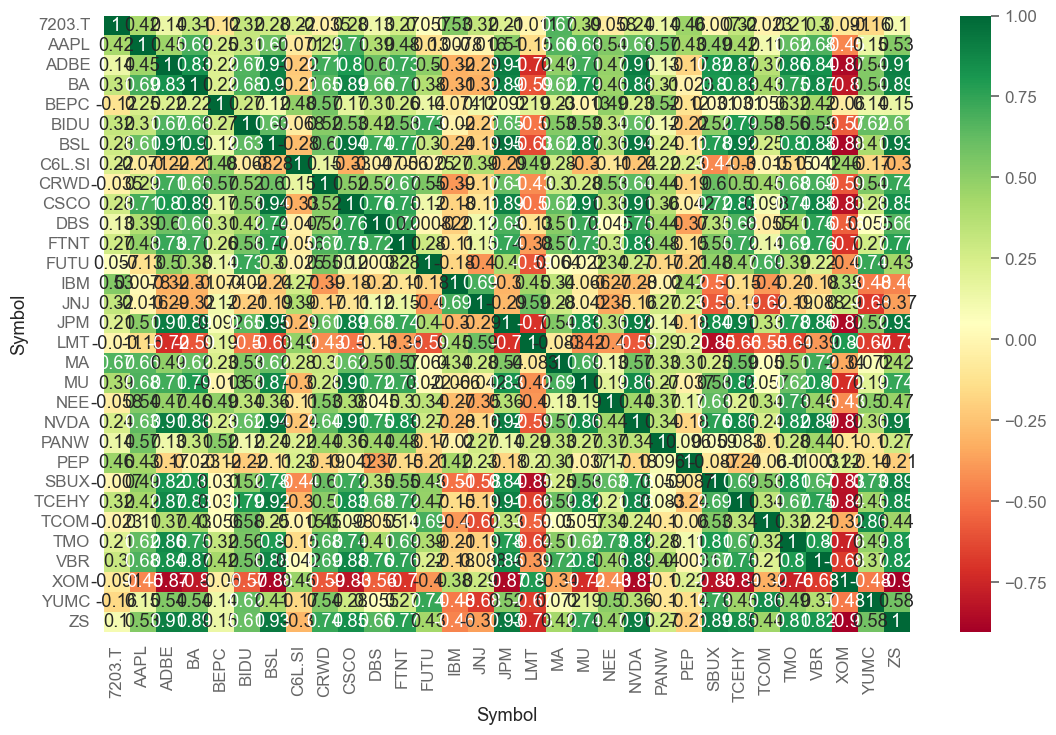

<Figure size 1000x600 with 0 Axes>

In [24]:
correlations=analyser.correlation_matrix()
correlations

In [46]:
correlations.to_excel("correlations.xlsx")

In [48]:
basic_metrics = analyser.basic_metrics()

In [49]:
basic_metrics.to_excel("basic_metrix.xlsx")

In [7]:
def decide_buy_sell(x):
    #print(x)
    if(x['Fame_French_yearly_returns'] > x['2022_market_returns'] + 0.05):
        return "STRONG BUY"
    elif(x['Fame_French_yearly_returns'] > x['2022_market_returns'] + 0.02):
        return "BUY"
    else:
        return "SELL"

# getting 2021 returns
import math
def calculate_2021_returns(tickers):
    data = get_data(tickers = tickers,start = dt.date(2021,1,1),end=dt.date(2021,12,31))
    soln=data.resample('Y').last().pct_change()
    #print(soln.columns)
    for i in list(soln.columns):
        
        soln[i] = soln[i].apply(lambda x : qs.stats.monthly_returns(data[i]).loc["2021"]['EOY'] if math.isnan(x) else x)

    return soln,data


def get_data(start,end,data_source = "yahoo",tickers= []):
        symbols=[]
        if(len(tickers) == 0):
            tickers=tickers

        for ticker in tickers:  
            try:   
                r = web.DataReader(ticker,data_source, start,end) 
            except :
                print(ticker)
            
                continue  
            # add a symbol column   
            r['Symbol'] = ticker    
            symbols.append(r)
        # concatenate into df
        df = pd.concat(symbols)
        df = df.reset_index()
        df = df[['Date', 'Close', 'Symbol']]
        df_pivot=df.pivot('Date','Symbol','Close').reset_index()
        df_pivot.set_index("Date",inplace=True)
        return df_pivot

In [ ]:
returns_2021,d = calculate_2021_returns(list(analysed_data.index))
returns_2021 = returns_2021[returns_2021.index.year ==2021]
analysed_data['2021_market_returns']=returns_2021.iloc[0]

# 2022 returns
returns_2022 = []
for i in analyser.data.columns:
   returns_2022.append(qs.stats.monthly_returns(analyser.data[i]).loc["2022"]["EOY"])
returns_2022
analysed_data['2022_market_returns']=returns_2022


# with threshold of 1%
analysed_data['Buy/Sell'] = analysed_data.apply(decide_buy_sell,axis=1)
returns_2021 = returns_2021[returns_2021.index.year ==2021]
analysed_data['2021_market_returns']=returns_2021.iloc[0]

analysed_data

In [9]:
analysed_data['diff'] = analysed_data['Fame_French_yearly_returns'] - analysed_data['2022_market_returns']

In [ ]:
analysed_data.head()

In [12]:
analysed_data.to_excel("famaFrench.xlsx")

In [54]:
analysed_data[analysed_data['Buy/Sell'] == 'SELL'].index

Index(['7203.T', 'IBM', 'JNJ', 'LMT', 'PEP', 'TCOM', 'XOM'], dtype='object', name='Symbol')

In [55]:
analysed_data[analysed_data['Buy/Sell'] != 'SELL'].index

Index(['AAPL', 'ADBE', 'BA', 'BEPC', 'BIDU', 'BSL', 'C6L.SI', 'CRWD', 'CSCO',
       'DBS', 'FTNT', 'FUTU', 'JPM', 'MA', 'MU', 'NEE', 'NVDA', 'PANW', 'SBUX',
       'TCEHY', 'TMO', 'VBR', 'YUMC', 'ZS'],
      dtype='object', name='Symbol')

In [ ]:
analysed_data[analysed_data['Buy/Sell'] == 'STRONG BUY'].index

# Diversification